In [ ]:
%run startup.py

In [1]:
# plt.style.use('bmh')
plt.style.use('ggplot')
# plt.style.use('seaborn')
# plt.style.use('default')
# plt.style.use('fivethirtyeight')

### 1. Data preprocessing

In [2]:
# Reading the data
df = pd.read_excel('data/SoyabeanData-Phase2.xlsx')
df['YEAR'] = df['YEAR'].astype(str)
print(df.shape)
df[:3]

(460, 33)


DISTRICTS  YEAR  YIELD  NDVI_JUN  NDVI_JUL  NDVI_AUG  NDVI_SEP  NDVI_OCT  \
0     Anuppur  2010   0.40      0.27      0.42      0.55      0.64      0.59   
1  Ashoknagar  2010   1.28      0.20      0.44      0.64      0.50      0.36   
2    Balaghat  2010   1.74      0.47      0.37      0.62      0.76      0.68   

   NDVI_NOV  LAI_JUN  LAI_JUL  LAI_AUG  LAI_SEP  LAI_OCT  LAI_NOV  ET_JUN  \
0      0.50     0.48     0.57     1.18     1.55     1.48     0.96    1.71   
1      0.37     0.27     0.55     1.57     1.68     0.62     0.46    0.60   
2      0.65     1.01     0.67     1.25     2.36     2.12     1.79    5.37   

   ET_JUL  ET_AUG  ET_SEP  ET_OCT  ET_NOV  LST_JUN  LST_JUL  LST_AUG  LST_SEP  \
0   14.64   23.41   28.39   21.57   15.75   316.20   308.32   303.46   302.58   
1    9.70   20.63   21.71   12.30   10.64   318.60   309.72   301.61   305.58   
2   18.70   27.47   35.17   25.44   19.99   313.59   300.98   300.47   301.02   

   LST_OCT  LST_NOV  RF_JUN  RF_JUL  RF_AUG  RF_SEP  RF_OCT  RF_NOV  
0   303.18   302.78    3.68   13.40    9.78    8.33    1.45    0.18  
1   309.41   305.86    0.80   12.21    8.29    6.26    0.27    0.83  
2   301.08   300.58    4.44   16.39   16.12   12.96    1.70    0.56

In [3]:
# check for nulls
print(df.isnull().sum().sum())
df.loc[df.isnull().any(axis = 1)]

1


DISTRICTS  YEAR  YIELD  NDVI_JUN  NDVI_JUL  NDVI_AUG  NDVI_SEP  NDVI_OCT  \
155     Harda  2013   0.27      0.11      0.11      0.39      0.58      0.49   

     NDVI_NOV  LAI_JUN  LAI_JUL  LAI_AUG  LAI_SEP  LAI_OCT  LAI_NOV  ET_JUN  \
155      0.46     0.22     0.13     0.66     1.43     1.16     0.79    1.59   

     ET_JUL  ET_AUG  ET_SEP  ET_OCT  ET_NOV  LST_JUN  LST_JUL  LST_AUG  \
155     nan   30.49   28.27   17.29    7.49   315.77   300.69   300.56   

     LST_SEP  LST_OCT  LST_NOV  RF_JUN  RF_JUL  RF_AUG  RF_SEP  RF_OCT  RF_NOV  
155   305.73   307.58   304.33   13.64   22.24   11.26    4.65    2.29    0.00

In [4]:
# let's fill it as previous year value
feat = 'ET_JUL'
f11 = df.YEAR == '2012'
f12 = df.YEAR == '2013'

f2 = df.DISTRICTS == 'Harda'
val = df[f11&f2][feat].values[0]

df.loc[f12&f2,feat] = val

In [5]:
# create fake variables Yield by month (we will set them as constanst)
feat = 'YIELD'
for f in ['JUN','JUL','AUG','SEP','OCT','NOV']:
    df[feat+'_'+f] = df[feat]

In [6]:
# transform data from wide to long format
cols = list(df.columns)
df1 = pd.melt(df, id_vars = cols[:2], value_vars=cols[3:])
df1['DATE'] = df1.YEAR.astype(str) + ' ' + df1.variable.map(lambda x: x.split('_')[1])
df1['DATE'] = pd.to_datetime(df1['DATE'])
df1['DATE_STR'] = df1.DATE.astype(str).str[:7]
df1['MONTH'] = df1.DATE.astype(str).str[5:7]
df1['feat'] = df1.variable.map(lambda x: x.split('_')[0])
del df1['variable']
print(df1.shape)
df1[:3]

(16560, 7)


DISTRICTS  YEAR  value       DATE DATE_STR MONTH  feat
0     Anuppur  2010   0.27 2010-06-01  2010-06    06  NDVI
1  Ashoknagar  2010   0.20 2010-06-01  2010-06    06  NDVI
2    Balaghat  2010   0.47 2010-06-01  2010-06    06  NDVI

In [13]:
# transform the data to wide format with features
df12 = pd.pivot_table(df1, index = 'DATE', columns = ['feat','DISTRICTS'], values = 'value')
print(df12.shape)
df12[:3]

In [7]:
# create different variables
list_month = sorted(df1.DATE_STR.unique())

list_year = sorted(df.YEAR.unique())

list_feats = list(df1.feat.unique())

list_regions = sorted(df1.DISTRICTS.unique())

list_colors = ['#008500','#00CC00','#67E667','#1240AB','#6C8CD5','#FF7800']
dict_colors = dict([(k,v) for k,v in zip(list_feats, list_colors)])

### 2. Graphical methods

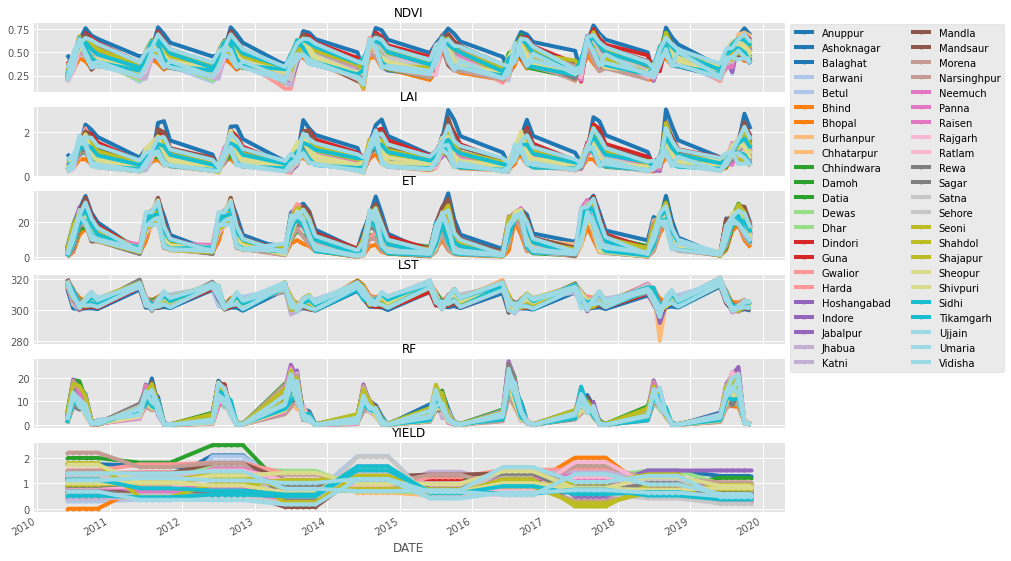

In [14]:
# basic plot
_, ax = plt.subplots(6,1, figsize = (12,10), sharex = True)
for i,feat in enumerate(list_feats):
    _ = df12[feat].iloc[:,:].plot(style = '-' if feat!='YIELD' else '.-', ax = ax[i], cmap = 'tab20', legend = None)
    _ = ax[i].set_title(feat, fontsize = 12)
_ = plt.legend(bbox_to_anchor=(1, 7.05), loc="upper left", ncol = 2)

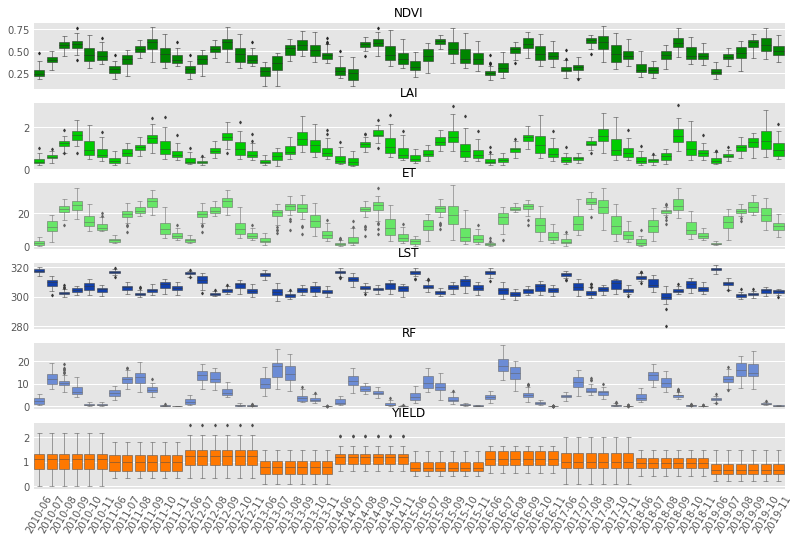

In [15]:
# boxplot
_, ax = plt.subplots(6,1, figsize = (12,8), sharex = True)
for i,feat in enumerate(list_feats):
    filt = df1.feat == feat
    color = list_colors[i]
    p = sns.boxplot(x=df1[filt].DATE_STR, y=df1[filt]['value'], order=list_month, ax = ax[i], linewidth=0.5, saturation=1, fliersize = 2, color=color, palette=None)
    _ = p.set_title(feat, fontsize = 12)
    _ = p.set_ylabel('')
    _ = p.set_xlabel('')
    _ = plt.xticks(rotation = 60)

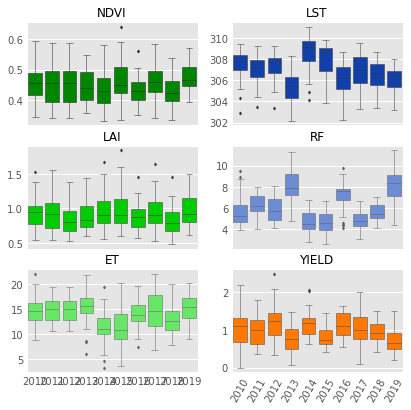

In [20]:
# yearly boxplot
df2 = df1.groupby(['YEAR','DISTRICTS','feat'])['value'].mean().reset_index()

_, ax = plt.subplots(3,2, figsize = (6,6), sharex = True)
for i,feat in enumerate(['NDVI', 'LAI', 'ET', 'LST', 'RF', 'YIELD'][:3]):
    filt = df2.feat == feat
    p = sns.boxplot(x=df2[filt].YEAR, y=df2[filt]['value'], order = list_year, ax = ax[i,0], linewidth=0.5, saturation=1, fliersize = 2, color = list_colors[i])
    _ = p.set_title(feat, fontsize = 12)
    _ = p.set_ylabel('')
    _ = p.set_xlabel('')
_ = plt.xticks(rotation = 60)
for i,feat in enumerate(['NDVI', 'LAI', 'ET', 'LST', 'RF', 'YIELD'][3:]):
    filt = df2.feat == feat
    p = sns.boxplot(x=df2[filt].YEAR, y=df2[filt]['value'], order = list_year, ax = ax[i,1], linewidth=0.5, saturation=1, fliersize = 2, color = list_colors[i+3])
    _ = p.set_title(feat, fontsize = 12)
    _ = p.set_ylabel('')
    _ = p.set_xlabel('')
_ = plt.xticks(rotation = 60)

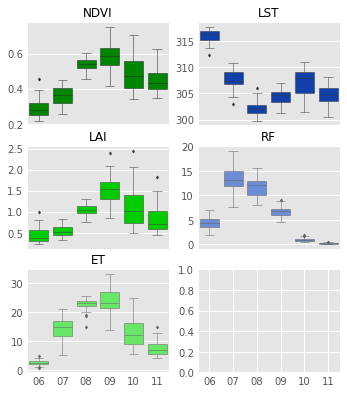

In [21]:
# monthly boxplot
df2 = df1.groupby(['MONTH','DISTRICTS','feat'])['value'].mean().reset_index()
list1 = sorted(df2.MONTH.unique())

_, ax = plt.subplots(3,2, figsize = (5,6), sharex = True)
for i,feat in enumerate(['NDVI', 'LAI', 'ET', 'LST', 'RF', 'YIELD'][:3]):
    filt = df2.feat == feat
    p = sns.boxplot(x=df2[filt].MONTH, y=df2[filt]['value'], order = list1, ax = ax[i,0], linewidth=0.5, saturation=1, fliersize = 2, color = list_colors[i])
    _ = p.set_title(feat, fontsize = 12)
    _ = p.set_ylabel('')
    _ = p.set_xlabel('')

for i,feat in enumerate(['NDVI', 'LAI', 'ET', 'LST', 'RF', 'YIELD'][3:]):
    if feat == 'YIELD':
        continue
    filt = df2.feat == feat
    p = sns.boxplot(x=df2[filt].MONTH, y=df2[filt]['value'], order = list1, ax = ax[i,1], linewidth=0.5, saturation=1, fliersize = 2, color = list_colors[i+3])
    _ = p.set_title(feat, fontsize = 12)
    _ = p.set_ylabel('')
    _ = p.set_xlabel('')

### 3. Modelling

In [ ]:
# create dataset with seasonal data


In [ ]:
# transform the data to wide format with features
df12 = pd.pivot_table(df1, index = 'DATE', columns = ['feat','DISTRICTS'], values = 'value')
print(df12.shape)
df12[:3]

In [31]:
print(df12.shape)
df12[:3]

(60, 276)


feat            ET                                                           \
DISTRICTS  Anuppur Ashoknagar Balaghat Barwani Betul Bhind Bhopal Burhanpur   
DATE                                                                          
2010-06-01    1.71       0.60     5.37    3.65  4.37  0.03   1.67      4.04   
2010-07-01   14.64       9.70    18.70   17.64 17.62  2.74  11.37     15.14   
2010-08-01   23.41      20.63    27.47   20.58 24.98 12.69  21.89     23.74   

feat                                                                    \
DISTRICTS  Chhatarpur Chhindwara Damoh Datia Dewas  Dhar Dindori  Guna   
DATE                                                                     
2010-06-01       0.22       4.87  1.19  0.07  2.58  2.44    3.59  0.61   
2010-07-01      10.88      18.22 10.93  4.46 14.11 16.87   15.01  8.77   
2010-08-01      21.41      26.34 22.75 15.95 24.37 20.52   23.61 21.58   

feat                                                                      \
DISTRICTS  Gwalior Harda Hoshangabad Indore Jabalpur Jhabua Katni Mandla   
DATE                                                                       
2010-06-01    0.08  2.89        3.39   2.97     2.13   3.25  0.97   3.72   
2010-07-01    5.11 14.41       15.94  14.87    12.27  18.24  9.13  15.68   
2010-08-01   19.27 23.12       28.61  19.65    21.60  21.97 21.89  26.32   

feat                                                                        \
DISTRICTS  Mandsaur Morena Narsinghpur Neemuch Panna Raisen Rajgarh Ratlam   
DATE                                                                         
2010-06-01     1.23   0.06        3.50    1.10  0.26   2.35    0.94   1.81   
2010-07-01     9.28   3.77       13.73    9.82 10.23  15.43    8.21  15.17   
2010-08-01    20.43  18.31       24.65   21.55 24.57  26.09   21.07  24.28   

feat                                                                         \
DISTRICTS   Rewa Sagar Satna Sehore Seoni Shahdol Shajapur Sheopur Shivpuri   
DATE                                                                          
2010-06-01  0.11  1.55  0.20   2.19  4.21    1.63     1.26    0.11     0.24   
2010-07-01  4.96 11.04  7.28  12.59 18.38   12.09     9.89    7.32     8.77   
2010-08-01 19.04 22.14 20.61  27.08 24.78   23.45    23.55   23.09    22.31   

feat                                                 LAI                      \
DISTRICTS  Sidhi Tikamgarh Ujjain Umaria Vidisha Anuppur Ashoknagar Balaghat   
DATE                                                                           
2010-06-01  0.49      0.22   1.68   1.36    1.07    0.48       0.27     1.01   
2010-07-01  7.69      8.58  13.30  14.12    9.68    0.57       0.55     0.67   
2010-08-01 21.26     19.40  24.49  24.05   23.58    1.18       1.57     1.25   

feat                                                                         \
DISTRICTS  Barwani Betul Bhind Bhopal Burhanpur Chhatarpur Chhindwara Damoh   
DATE                                                                          
2010-06-01    0.25  0.62  0.21   0.28      0.41       0.33       0.65  0.40   
2010-07-01    0.49  0.65  0.34   0.59      0.61       0.68       0.73  0.61   
2010-08-01    0.77  0.99  0.76   1.45      0.86       1.29       1.00  1.19   

feat                                                                       \
DISTRICTS  Datia Dewas Dhar Dindori Guna Gwalior Harda Hoshangabad Indore   
DATE                                                                        
2010-06-01  0.25  0.34 0.21    0.77 0.27    0.28  0.38        0.55   0.29   
2010-07-01  0.42  0.58 0.52    0.78 0.62    0.60  0.46        0.46   0.66   
2010-08-01  1.04  1.22 1.01    1.30 1.59    1.08  1.27        0.99   1.21   

feat                                                                         \
DISTRICTS  Jabalpur Jhabua Katni Mandla Mandsaur Morena Narsinghpur Neemuch   
DATE                                                                          
2010-06-01     0.44   0

In [49]:
def ts_predict_exponential(df):
    '''
    Функция для получения прогнозов по модели exponential smoothing.
    Input:
        df      - dataframe, у которого индексы это даты, а столбцы - переменные, по которым прогнозировать;
    Output:
        dataframe с прогнозами
    '''
    
    from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
    
    def _predict_exponential(x):
        model = ExponentialSmoothing(x, trend="add", seasonal="add", seasonal_periods=6, damped = True)

        fit1 = model.fit()
        pred1 = fit1.forecast(x.shape[0])
        pred1.index = x.index
        return pred1

    return df.apply(_predict_exponential, axis = 0)

In [37]:
df12.iloc[:2,:2]

feat            ET           
DISTRICTS  Anuppur Ashoknagar
DATE                         
2010-06-01    1.71       0.60
2010-07-01   14.64       9.70

In [53]:
df_pred.plot()

<AxesSubplot:xlabel='DATE'>

In [52]:
df_real.plot()

<AxesSubplot:xlabel='DATE'>

In [51]:
df_real = df12.iloc[:,:5]
df_pred = ts_predict_exponential(df_real)

C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No su

In [54]:
df12['YIELD'][:3]

DISTRICTS   Anuppur  Ashoknagar  Balaghat  Barwani  Betul  Bhind  Bhopal  \
DATE                                                                       
2010-06-01     0.40        1.28      1.74     0.29   1.10   0.00    1.16   
2010-07-01     0.40        1.28      1.74     0.29   1.10   0.00    1.16   
2010-08-01     0.40        1.28      1.74     0.29   1.10   0.00    1.16   

DISTRICTS   Burhanpur  Chhatarpur  Chhindwara  Damoh  Datia  Dewas  Dhar  \
DATE                                                                       
2010-06-01       0.52        0.41        1.99   1.46   0.58   1.25  1.32   
2010-07-01       0.52        0.41        1.99   1.46   0.58   1.25  1.32   
2010-08-01       0.52        0.41        1.99   1.46   0.58   1.25  1.32   

DISTRICTS   Dindori  Guna  Gwalior  Harda  Hoshangabad  Indore  Jabalpur  \
DATE                                                                       
2010-06-01     0.80  1.19     1.50   1.38         0.64    1.14      1.19   
2010-07-01     0.80  1.19     1.50   1.38         0.64    1.14      1.19   
2010-08-01     0.80  1.19     1.50   1.38         0.64    1.14      1.19   

DISTRICTS   Jhabua  Katni  Mandla  Mandsaur  Morena  Narsinghpur  Neemuch  \
DATE                                                                        
2010-06-01    0.71   0.41    0.65      1.36    1.48         2.20     0.80   
2010-07-01    0.71   0.41    0.65      1.36    1.48         2.20     0.80   
2010-08-01    0.71   0.41    0.65      1.36    1.48         2.20     0.80   

DISTRICTS   Panna  Raisen  Rajgarh  Ratlam  Rewa  Sagar  Satna  Sehore  Seoni  \
DATE                                                                            
2010-06-01   1.12    0.92     0.86    1.27  0.69   0.89   0.56    1.30   0.94   
2010-07-01   1.12    0.92     0.86    1.27  0.69   0.89   0.56    1.30   0.94   
2010-08-01   1.12    0.92     0.86    1.27  0.69   0.89   0.56    1.30   0.94   

DISTRICTS   Shahdol  Shajapur  Sheopur  Shivpuri  Sidhi  Tikamgarh  Ujjain  \
DATE                                                                         
2010-06-01     1.79      1.12     1.73      1.00   0.52       1.15    1.39   
2010-07-01     1.79      1.12     1.73      1.00   0.52       1.15    1.39   
2010-08-01     1.79      1.12     1.73      1.00   0.52       1.15    1.39   

DISTRICTS   Umaria  Vidisha  
DATE                         
2010-06-01    0.68     1.11  
2010-07-01    0.68     1.11  
2010-08-01    0.68     1.11

In [ ]:
# transform the data to wide format with features
df12 = pd.pivot_table(df1, index = 'DATE', columns = ['feat','DISTRICTS'], values = 'value')
print(df12.shape)
df12[:3]

In [33]:
# metrics for validation
def ts_metrics(y_true, y_pred):
    return {
        'mae': metrics.mean_absolute_error(y_true, y_pred),
        'mse': metrics.mean_squared_error(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
        'smape': np.mean(np.abs( 2*(y_true - y_pred) / (y_true+np.abs(y_pred)))),
    }

In [ ]:
# simple method

In [32]:
# build training and test sets
for train_ind,test_ind in cv_index:
    t1,t2 = train_ind
    s1,s2 = test_ind    
    x  = df_out2[t1:t2].iloc[:,ind]
    xt = df_out2[s1:s2].iloc[:,ind]

In [30]:
df12[-12:]

feat            ET                                                           \
DISTRICTS  Anuppur Ashoknagar Balaghat Barwani Betul Bhind Bhopal Burhanpur   
DATE                                                                          
2018-06-01    2.93       1.04     9.52    4.35  5.94  0.09   4.68      5.13   
2018-07-01   18.34       6.83    23.07   16.27 21.20  3.36  12.62     20.42   
2018-08-01   21.57      20.06    20.52   19.83 21.93 13.66  21.10     22.64   
2018-09-01   28.91      21.52    35.24   22.99 30.87 19.17  20.59     28.41   
2018-10-01   16.06       6.27    21.08    9.59 15.17  5.84   7.23     15.03   
2018-11-01    7.62       3.83    11.21    4.87  7.59  4.03   5.02      8.36   
2019-06-01    2.03       1.57     1.00    1.31  0.72  0.80   1.70      1.63   
2019-07-01   20.48       8.53    22.25   18.36 21.07  3.96  11.37     17.88   
2019-08-01   21.25      21.18    20.71   20.94 22.31 15.03  18.18     22.16   
2019-09-01   25.29      21.18    28.13   22.92 30.31 18.65  21.27     28.92   
2019-10-01   23.05      14.02    28.59   22.08 26.19  9.65  16.53     25.32   
2019-11-01   15.78       9.64    19.30   14.28 17.47  5.45  10.15     19.19   

feat                                                                    \
DISTRICTS  Chhatarpur Chhindwara Damoh Datia Dewas  Dhar Dindori  Guna   
DATE                                                                     
2018-06-01       0.65       6.16  1.10  0.29  3.22  3.04    4.92  1.22   
2018-07-01       8.57      19.87 10.73  3.92 14.45 15.63   17.06  7.13   
2018-08-01      21.83      23.06 22.29 17.73 21.19 19.68   23.59 20.18   
2018-09-01      23.96      31.85 26.54 23.26 22.60 21.73   29.69 23.66   
2018-10-01       9.05      16.56 10.65  8.24  9.20  8.47   17.24  7.63   
2018-11-01       5.31       8.42  6.04  4.15  7.55  6.42    9.10  4.30   
2019-06-01       1.72       0.91  1.46  1.20  1.03  1.49    2.14  1.73   
2019-07-01      10.29      20.92 12.07  5.08 16.55 17.87   21.67  9.00   
2019-08-01      21.23      22.81 24.49 16.88 22.51 21.53   21.18 20.86   
2019-09-01      23.34      30.74 27.52 22.84 21.19 21.02   26.59 20.21   
2019-10-01      16.60      25.33 19.70 13.84 18.89 18.96   27.36 15.28   
2019-11-01       9.45      16.90 11.40  7.06 12.26 11.98   17.74 10.19   

feat                                                                      \
DISTRICTS  Gwalior Harda Hoshangabad Indore Jabalpur Jhabua Katni Mandla   
DATE                                                                       
2018-06-01    0.40  3.98        5.14   2.73     1.70   3.37  1.25   4.13   
2018-07-01    4.33 20.59       16.17  14.29    13.35  18.69 10.21  18.66   
2018-08-01   18.81 20.97       18.85  21.15    21.65  21.03 20.83  21.80   
2018-09-01   23.98 24.53       28.99  19.55    27.17  24.49 29.18  31.47   
2018-10-01    9.40  9.49       13.96   6.83    14.08  11.42 14.72  17.42   
2018-11-01    4.84  6.41        6.81   8.07     7.75   6.03  7.03   9.05   
2019-06-01    1.60  0.51        1.12   1.27     1.94   2.21  2.12   1.40   
2019-07-01    7.12 18.57       19.99  18.29    14.78  17.79 13.48  21.45   
2019-08-01   18.33 23.31       22.36  20.18    21.47  21.66 20.79  23.34   
2019-09-01   22.73 26.50       28.71  18.59    26.76  24.88 25.93  29.20   
2019-10-01   15.35 21.60       24.10  16.45    23.40  21.65 21.42  29.01   
2019-11-01    8.17 13.56       13.57  12.12    13.09  12.38 12.76  16.77   

feat                                                                        \
DISTRICTS  Mandsaur Morena Narsinghpur Neemuch Panna Raisen Rajgarh Ratlam   
DATE                                                                         
2018-06-01     0.73   0.25        5.23    0.75  0.44   4.27    2.18   1.56   
2018-07-01    11.91   3.46       14.88   10.06  8.89  14.31    9.55  12.17   
2018-08-01    21.34  15.91       21.39   20.05 22.67  20.22   21.57  20.34   
2018-09-01    19.49  20.97       26.41   20.71 29.71  26.64   19.98  20.75   
2018-10-01     4

In [ ]:
def ts_metrics(y_true, y_pred):
    return {
        'mae': metrics.mean_absolute_error(y_true, y_pred),
        'mse': metrics.mean_squared_error(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
        'smape': np.mean(np.abs( 2*(y_true - y_pred) / (y_true+np.abs(y_pred)))),
    }

def ts_predict_prophet(df, t1 = 90):
    '''
    Функция для получения прогнозов по модели prophet.
    Input:
        df - dataframe, у которого индексы это даты, а столбцы - переменные, по которым прогнозировать;
        t1 - количество дней для прогнозирования
    Output:
        dataframe с прогнозами
    '''
    from prophet import Prophet
    from prophet.make_holidays import make_holidays_df

    def _predict_prophet(x):
        # 1) prepare dataframe 
        x = x.reset_index()
        x.columns = ['ds','y']

        # 2) build model
        year_list = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
        holidays = make_holidays_df(year_list=year_list, country='JP')
        m = Prophet(holidays=holidays,
                    daily_seasonality=False,
                    changepoint_prior_scale=0.015)
        m.add_seasonality(name='monthly', period=20.5, fourier_order=5)
        # m.add_regressor('Cl_lr')
        m.fit(x)

        # 3) predict
        df = m.make_future_dataframe(periods=t1, freq='d')
        df = df[df.ds.dt.dayofweek < 5]
        out = m.predict(df).set_index('ds')['yhat']
        return out

    return df.apply(_predict_prophet, axis = 0)

In [22]:
df1

DISTRICTS  YEAR  value       DATE DATE_STR MONTH   feat
0         Anuppur  2010   0.27 2010-06-01  2010-06    06   NDVI
1      Ashoknagar  2010   0.20 2010-06-01  2010-06    06   NDVI
2        Balaghat  2010   0.47 2010-06-01  2010-06    06   NDVI
3         Barwani  2010   0.25 2010-06-01  2010-06    06   NDVI
4           Betul  2010   0.36 2010-06-01  2010-06    06   NDVI
...           ...   ...    ...        ...      ...   ...    ...
16555       Sidhi  2019   0.36 2019-11-01  2019-11    11  YIELD
16556   Tikamgarh  2019   0.42 2019-11-01  2019-11    11  YIELD
16557      Ujjain  2019   0.47 2019-11-01  2019-11    11  YIELD
16558      Umaria  2019   0.49 2019-11-01  2019-11    11  YIELD
16559     Vidisha  2019   0.58 2019-11-01  2019-11    11  YIELD

[16560 rows x 7 columns]

In [23]:
df2

MONTH DISTRICTS   feat  value
0       06   Anuppur     ET   3.68
1       06   Anuppur    LAI   0.60
2       06   Anuppur    LST 314.68
3       06   Anuppur   NDVI   0.34
4       06   Anuppur     RF   5.48
...    ...       ...    ...    ...
1651    11   Vidisha    LAI   0.49
1652    11   Vidisha    LST 306.83
1653    11   Vidisha   NDVI   0.37
1654    11   Vidisha     RF   0.15
1655    11   Vidisha  YIELD   0.97

[1656 rows x 4 columns]